# Senzing and Neo4j Integration Example

## Set up the Python environment

First, we need to import the Python library dependencies which are required for the code we'll be running.

In [15]:
from dataclasses import dataclass, field
import csv
import json
import os
import pathlib
import sys
import typing

from icecream import ic
from tqdm import tqdm
import dotenv
import matplotlib.pyplot as plt
import neo4j
import pandas as pd
import seaborn as sns
import watermark

%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


Show a "watermark" of which versions are being used for system componenents and library dependencies. This may help in case you need to troubleshoot the dependencies on your system, e.g., if there's some conflict during installation.

In [3]:
%watermark
%watermark --iversions

Last updated: 2024-03-18T09:36:29.244588-07:00

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.22.2

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
csv       : 1.0
watermark : 2.4.3
neo4j     : 5.18.0
sys       : 3.11.0 (v3.11.0:deaf509e8f, Oct 24 2022, 14:43:23) [Clang 13.0.0 (clang-1300.0.29.30)]
json      : 2.0.9
matplotlib: 3.8.3
pandas    : 2.2.1



## Examine the input datasets

We will use three datasets which describe businesses (names, addresses, etc.) within the Las Vegas metropolitan area:

  - SafeGraph `Places of Interest` (POI)
  - US Dept of Labor `Wage and Hour Compliance Action Data` (WHISARD)
  - US Small Business Administration `PPP Loans over $150K` (PPP)

Two of these datasets are public, and one is available commercially.
You can obtain each dataset from the links given below.

Since we only need a subset of each dataset, first let's define a utility function to remove unneeded columns from a Pandas `DataFrame` object.

In [3]:
def sample_df (
    df: pd.DataFrame,
    cols_keep: typing.Set[ typing.Any ],
    ) -> pd.DataFrame:
    """
Remove all but the specified columns from the given Pandas dataframe.
https://stackoverflow.com/a/51285940/1698443
    """
    diff: typing.Set[ typing.Any ] = set(df.columns) - cols_keep
    
    return df.drop(
        diff,
        axis = 1,
        inplace = False,
    )

### Load the SafeGraph Places dataset

Load the `Places of Interest` (POI) dataset for Las Vegas, from SafeGraph: <https://www.safegraph.com/products/places>

In [4]:
poi_path: pathlib.Path = pathlib.Path("lv_data") / "poi.json"

df_poi: pd.DataFrame = pd.DataFrame.from_dict(
    [ json.loads(line) for line in poi_path.open(encoding = "utf-8") ],
)

In [5]:
df = sample_df(
    df_poi,
    set([
        "RECORD_TYPE",
        "DATA_SOURCE",
        "RECORD_ID",
        "LOCATION_NAME_ORG",
        "TOP_CATEGORY",
        "SUB_CATEGORY",
        "NAICS_CODE",
        "BUSINESS_GEO_LATITUDE",
        "BUSINESS_GEO_LONGITUDE",
        "PHONE_NUMBER",
        "BUSINESS_ADDR_FULL",
    ]),
)

In [6]:
df.head()

,DATA_SOURCE,RECORD_ID,RECORD_TYPE,LOCATION_NAME_ORG,TOP_CATEGORY,SUB_CATEGORY,NAICS_CODE,BUSINESS_GEO_LATITUDE,BUSINESS_GEO_LONGITUDE,PHONE_NUMBER,BUSINESS_ADDR_FULL
0,SAFEGRAPH,225-222@5yv-j92-tn5,ORGANIZATION,Cantwell Michelle L Atty,Legal Services,Offices of Lawyers,541110,36.145647,-115.186399,+17023627800,3320 W Sahara Ave Las Vegas NV 89102-3223
1,SAFEGRAPH,226-222@5yv-hmm-whq,ORGANIZATION,Pieology Pizzeria,Restaurants and Other Eating Places,Limited-Service Restaurants,722513,36.144906,-115.332644,+17023314454,10965 Lavender Hill Dr Ste 130 Las Vegas NV 89...
2,SAFEGRAPH,22s-222@5yv-jbz-jgk,ORGANIZATION,Ellen Peneyra,Offices of Other Health Practitioners,Offices of All Other Miscellaneous Health Prac...,621399,36.10289,-115.121807,+17027397716,2275 Renaissance Dr Ste D Las Vegas NV 89119-6797
3,SAFEGRAPH,28m-222@5yv-hmp-v4v,ORGANIZATION,Stanford Jackson,Offices of Other Health Practitioners,Offices of All Other Miscellaneous Health Prac...,621399,36.143386,-115.272694,+17025623569,8321 W Sahara Ave Apt 2007 Las Vegas NV 89117-...
4,SAFEGRAPH,22g-222@5yv-j9q-c89,ORGANIZATION,Praise Templechurch,Religious Organizations,Religious Organizations,813110,36.199677,-115.154611,+17026386036,952 Balzar Ave Las Vegas NV 89106-2204


In [7]:
df.describe().loc[[ "count", "freq", "unique", ]]

,DATA_SOURCE,RECORD_ID,RECORD_TYPE,LOCATION_NAME_ORG,TOP_CATEGORY,SUB_CATEGORY,NAICS_CODE,BUSINESS_GEO_LATITUDE,BUSINESS_GEO_LONGITUDE,PHONE_NUMBER,BUSINESS_ADDR_FULL
count,98806,98806,98806,98806,98806,83024,98806,98806,98806,80640,92327
freq,98806,1,98806,438,10295,7728,7728,12,15,324,262
unique,1,98806,1,84643,230,396,566,69765,73723,58881,43900


### Load the DoL WHISARD dataset

Load the `Wage and Hour Compliance Action Data` (WHISARD) dataset for Las Vegas, from the US Department of Labor: <https://enforcedata.dol.gov/views/data_summary.php>

In [8]:
dol_path: pathlib.Path = pathlib.Path("lv_data") / "dol.csv"

df_dol: pd.DataFrame = pd.read_csv(
    dol_path,
    dtype = str,
    encoding = "utf-8",
)

In [9]:
df = sample_df(
    df_dol,
    set([
        "RECORD_TYPE",
        "DATA_SOURCE",
        "RECORD_ID",
        "BUSINESS_NAME_ORG",
        "LEGAL_NAME_ORG",
        "BUSINESS_ADDR_LINE1",
        "BUSINESS_ADDR_CITY",
        "BUSINESS_ADDR_STATE",
        "BUSINESS_ADDR_POSTAL_CODE",
    ]),
)

In [10]:
df.head()

,RECORD_TYPE,DATA_SOURCE,RECORD_ID,BUSINESS_NAME_ORG,LEGAL_NAME_ORG,BUSINESS_ADDR_LINE1,BUSINESS_ADDR_CITY,BUSINESS_ADDR_STATE,BUSINESS_ADDR_POSTAL_CODE
0,ORGANIZATION,DoL_WHISARD,7017,Fabulous Freddy's (Trailwood),Fabulous LLC,9611 Trail Wood Drive,Las Vegas,NV,89134
1,ORGANIZATION,DoL_WHISARD,7018,Boulder Station Hotel & Casino,"Boulder Station, Inc.",4111 Boulder Hwy,Las Vegas,NV,89121
2,ORGANIZATION,DoL_WHISARD,7021,MSI Landscaping,"MIST Systems International, Inc.","4820 Quality Court, #B",Las Vegas,NV,89103
3,ORGANIZATION,DoL_WHISARD,7022,Pastime Pools,Pastime Pools,731 Memory Ln,Las Vegas,NV,89110
4,ORGANIZATION,DoL_WHISARD,7023,Steven Michaels,Steven Michaels,4108 Autum St,Las Vegas,NV,89120


In [11]:
df.describe().loc[[ "count", "freq", "unique", ]]

,RECORD_TYPE,DATA_SOURCE,RECORD_ID,BUSINESS_NAME_ORG,LEGAL_NAME_ORG,BUSINESS_ADDR_LINE1,BUSINESS_ADDR_CITY,BUSINESS_ADDR_STATE,BUSINESS_ADDR_POSTAL_CODE
count,1533,1533,1533,1532,1529,1532,1532,1532,1532
freq,1533,1533,1,10,17,4,1386,1514,160
unique,1,1,1533,1413,1359,1455,5,4,68


### Load the PPP Loans dataset

Load the `PPP Loans over $150K` (PPP) dataset for Las Vegas, from the US Small Business Administration: <https://data.sba.gov/dataset/ppp-foia>

In [12]:
ppp_path: pathlib.Path = pathlib.Path("lv_data") / "ppp.csv"

df_ppp: pd.DataFrame = pd.read_csv(
    ppp_path,
    dtype = str,
    encoding = "utf-8",
)

In [13]:
df_ppp.head()

,RECORD_TYPE,DATA_SOURCE,RECORD_ID,Loan_Range,BUSINESS_NAME_ORG,BUSINESS_ADDR_LINE1,BUSINESS_ADDR_CITY,BUSINESS_ADDR_STATE,BUSINESS_ADDR_POSTAL_CODE,NAICS_Code,Business_Type,OwnedByRaceEthnicity,OwnedBy,OwnedByVeteran,NonProfit,JobsReported,DateApproved,Lender,CD
0,ORGANIZATION,PPP_LOANS,7017,c $1-2 million,"INFINITY HOSPICE CARE OF LAS VEGAS, LLC",5110 N 40TH ST STE 107,PHOENIX,AZ,85018,623110,Limited Liability Company(LLC),Unanswered,Male Owned,Unanswered,NaN,137,05/01/2020,"JPMorgan Chase Bank, National Association",AZ-09
1,ORGANIZATION,PPP_LOANS,7018,"d $350,000-1 million",CLUB TATTOO LAS VEGAS LLC,1839 s. almaschool rd. ste 230,MESA,AZ,85210,812199,Limited Liability Company(LLC),Unanswered,Male Owned,Non-Veteran,NaN,15,05/01/2020,"JPMorgan Chase Bank, National Association",AZ-09
2,ORGANIZATION,PPP_LOANS,7021,"d $350,000-1 million","LAS VEGAS LABOR, LLC","10265 W Camelback Rd, Ste 104",PHOENIX,AZ,85037,111421,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,0,04/07/2020,"UMB Bank, National Association",AZ-03
3,ORGANIZATION,PPP_LOANS,7022,"e $150,000-350,000","FIRST CUP PARTNERS LAS VEGAS II, LLC","106 S Kyrene Rd, Ste 2",CHANDLER,AZ,85226,722511,Limited Liability Company(LLC),Unanswered,Male Owned,Non-Veteran,NaN,105,04/16/2020,"JPMorgan Chase Bank, National Association",AZ-09
4,ORGANIZATION,PPP_LOANS,7023,"e $150,000-350,000","FIRST CUP PARTNERS LAS VEGAS, LLC",2121 W Chandler Blvd Ste 106,Chandler,AZ,85224,NaN,Limited Liability Company(LLC),Unanswered,Male Owned,Non-Veteran,NaN,124,05/01/2020,"JPMorgan Chase Bank, National Association",AZ-09


In [14]:
df_ppp.describe().loc[[ "count", "freq", "unique", ]]

,RECORD_TYPE,DATA_SOURCE,RECORD_ID,Loan_Range,BUSINESS_NAME_ORG,BUSINESS_ADDR_LINE1,BUSINESS_ADDR_CITY,BUSINESS_ADDR_STATE,BUSINESS_ADDR_POSTAL_CODE,NAICS_Code,Business_Type,OwnedByRaceEthnicity,OwnedBy,OwnedByVeteran,NonProfit,JobsReported,DateApproved,Lender,CD
count,3488,3488,3488,3488,3487,3488,3488,3488,3488,3375,3485,3488,3488,3488,117,3247,3488,3488,3487
freq,3488,3488,1,2038,2,20,2645,3404,424,277,1532,3035,2390,2585,117,125,543,527,1696
unique,1,1,3488,5,3480,3293,66,20,118,496,13,6,3,3,1,287,91,239,41


## Run the Entity Resolution in Senzing

Launch a Linux server running Ubuntu 20.04 LTS server with 4 vCPU, 16 GB memory.

See: <https://senzing.zendesk.com/hc/en-us/articles/115002408867-Quickstart-Guide>

```bash
wget https://senzing-production-apt.s3.amazonaws.com/senzingrepo_1.0.1-1_amd64.deb
sudo apt install ./senzingrepo_1.0.1-1_amd64.deb
sudo apt update
sudo apt upgrade
```

Depending on the Linux distribution, this may require installing `libssl1.1` as well, which is described in
<https://stackoverflow.com/questions/73251468/e-package-libssl1-1-has-no-installation-candidate>:

```bash
wget http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb
```

Then install Senzing, which will be located in the `/opt/senzing/data/current` directory:

```bash
sudo apt install senzingapi
```

Now create a project `~/senzing` in the current user's home directory and set up its configuration:

```bash
python3 /opt/senzing/g2/python/G2CreateProject.py ~/senzing
cd ~/senzing
source setupEnv
./python/G2SetupConfig.py
```

Prepare to load our three datasets into Senzing as data sources:

```bash
./python/G2ConfigTool.py
	+ addDataSource SAFEGRAPH
	+ addDataSource DOL_WHISARD
	+ addDataSource PPP_LOANS
	+ save
	+ y
	+ quit
```

We'll specify using up to 16 threads, to parallelize the input process:

```bash
./python/G2Loader.py -f lv_data/poi.json -nt 16
./python/G2Loader.py -f lv_data/dol.csv -nt 16
./python/G2Loader.py -f lv_data/ppp.csv -nt 16
```

Finally, export the resolved entities as the `export.json` local file:

```bash
./python/G2Export.py -F JSON -o export.json
```

## Parse the results from Senzing

Let's define a `dataclass` to represent the parsed results from Senzing entity resolution.

In [4]:
@dataclass(order=False, frozen=False)
class Entity:  # pylint: disable=R0902
    """
A data class representing a resolved entity.
    """
    entity_id: id
    num_recs: int
    records: typing.Set[ str ] = field(default_factory = lambda: set([]))
    related: typing.Dict[ int, dict ] = field(default_factory = lambda: {})
    has_ref: bool = False

Parse the JSON data from the export, to build a dictionary of entities indexed by their unique identifiers. Also keep track of both the "resolved" and "related" records for each entity, to use for constructing the knowledge graph from these results.

In [5]:
export_path: pathlib.Path = pathlib.Path("export.json")
entities: dict = {}

with export_path.open() as fp:
    for line in tqdm(fp.readlines(), desc = "read JSON"):
        entity_dat: dict = json.loads(line)
        entity_id: int = entity_dat["RESOLVED_ENTITY"]["ENTITY_ID"]

        records: set = set([
            ".".join([ r["DATA_SOURCE"], r["RECORD_ID"] ]).upper()
            for r in entity_dat["RESOLVED_ENTITY"]["RECORDS"]
        ])

        entities[entity_id] = Entity(
            entity_id = entity_id,
            records = records,
            num_recs = len(records),
            related = {
                r["ENTITY_ID"]: r
                for r in entity_dat["RELATED_ENTITIES"]
            },
        )

read JSON: 100%|████████████████████████████████████████████████████████████████████████████████████| 99156/99156 [00:03<00:00, 31486.76it/s]


Let's examine one of the resolved entity objects, to see which fields are available

In [6]:
entity_dat

{'RESOLVED_ENTITY': {'ENTITY_ID': 438737,
  'RECORDS': [{'DATA_SOURCE': 'SAFEGRAPH',
    'RECORD_ID': 'zzw-222@5yv-c8t-t7q',
    'ENTITY_TYPE': 'GENERIC',
    'INTERNAL_ID': 438737,
    'ENTITY_KEY': '7A2952039A2EDAE86C89FF025284618BB47F5B0E',
    'ENTITY_DESC': 'Royalty Renee Salez',
    'MATCH_KEY': '',
    'MATCH_LEVEL': 0,
    'MATCH_LEVEL_CODE': '',
    'ERRULE_CODE': '',
    'LAST_SEEN_DT': '2024-03-12 18:54:15.638'}]},
 'RELATED_ENTITIES': []}

Now let's analyze the Senzing results, measuring how much the process of _entity resolution_ has consolidated records among the input datasets.

In [7]:
for entity in entities.values():
    if entity.num_recs > 1:
        entity.has_ref = True

        for inf_ent in entity.related.keys():
            entities[inf_ent].has_ref = True

edge_counts: typing.List[ int ] = [
    e.num_recs
    for e in entities.values()
    #if e.num_recs > 1
]

has_ref_ents: int = len([
    e for e in entities.values()
    if e.has_ref
])

In particular, it's helpful for planning about our eventual knowledge graph to understand the:

  - total number of entities
  - number of entities which have references (i.e., these will be linked within the knowledge graph)

In [8]:
ic(len(entities))
ic(has_ref_ents);

ic| len(entities): 99156
ic| has_ref_ents: 14063


Now visualize this as a histogram of the resolved entities versus their related records in the input datasets.

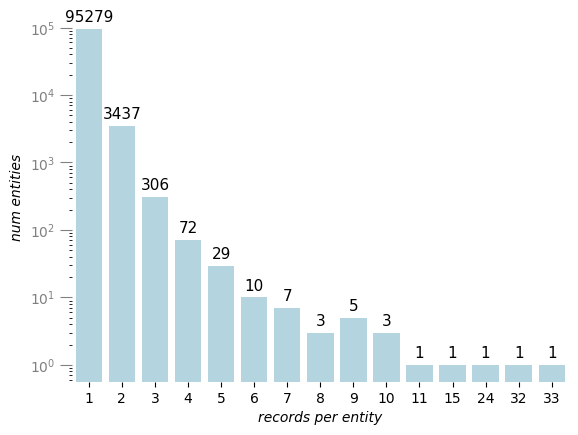

In [9]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "sans-serif"

y = sns.countplot(x = edge_counts, color = "lightblue")

y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "black", fontsize = 11)

plt.xlabel("records per entity", size = 10, fontstyle = "italic")
plt.ylabel("num entities", size = 10, fontstyle = "italic")

sns.despine(bottom = True, left = True)
plt.yscale("log")

From this analysis, more than 14K entities were linked to records through _entity resolution_.
These can be used to construct _nodes_, _properties_, and _relations_ in a knowledge graph.

In [10]:
num_rel_2: int = 3437
has_ref_ents - num_rel_2

10626

Of the linked entities, more than 10K have three or more records linked.
This is interesting since we're trying to link records across three datasets.
We'll get more specific stats later through Cypher graph queries in Neo4j.

## Build a Knowledge Graph in Neo4j

Set up a Bolt driver using our credentials for Neo4j Desktop

In [16]:
dotenv.load_dotenv(dotenv.find_dotenv())

bolt_uri: str = os.environ.get("NEO4J_BOLT")
username: str = os.environ.get("NEO4J_USER")
password: str = os.environ.get("NEO4J_PASS")

driver: neo4j.BoltDriver = neo4j.GraphDatabase.driver(
    bolt_uri,
    auth = ( username, password, ),
)

Delete the previous graph data...

In [22]:
with driver.session() as session:
    #session.run("MATCH (x) DETACH DELETE x")
    #session.run("DROP CONSTRAINT unique_record")
    #session.run("DROP CONSTRAINT unique_entity")
    pass

In [23]:
with driver.session() as session:
    query: str = """
CREATE CONSTRAINT unique_record 
    IF NOT EXISTS FOR (rec:Record) 
    REQUIRE rec.uid IS UNIQUE
    """
    
    session.run(query)

    query = """
CREATE CONSTRAINT unique_entity 
    IF NOT EXISTS FOR (ent:Entity) 
    REQUIRE ent.uid IS UNIQUE
    """
    
    session.run(query)

### Populate nodes from the dataset records

Define utility functions used for loading the graph data.

In [24]:
def get_property_keys (
    df: pd.DataFrame,
    ) -> typing.List[ str ]:
    """
Convert the column names from the given Pandas dataframe into Cypher property names.
    """
    return [
        name.lower().replace(" ", "_")
        for name in df.columns.values.tolist()
    ]


def safe_value (
    obj: typing.Any,
    ) -> typing.Any:
    """
Escape double quotes within string values.
    """
    if isinstance(obj, str):
        return obj.replace('"', "'")

    return obj

In [25]:
def format_merge_record (
    keys: typing.List[ str ],
    vals: list,
    ) -> str:
    """
Format one MERGE statement in Cypher for the values of a given Record.
    """
    safe_vals = [ safe_value(v) for v in vals ]
    row_dict: dict = dict(zip(keys, safe_vals))

    uid: str = row_dict["data_source"].upper() + "." + row_dict["record_id"]
    
    props: str = ", ".join([
        f"rec.{key} = \"{val}\""
        for key, val in row_dict.items()
    ])

    return f"""
MERGE (rec:Record {{ uid: \"{uid}\" }})
  ON CREATE
    SET {props}      
RETURN rec.data_source, rec.record_id
    """


def load_records (
    session: neo4j.Session,
    df: pd.DataFrame,
    ) -> None:
    """
Iterate over each Record from one dataset to load using Cypher.
    """
    keys: typing.List[ str ] = get_property_keys(df)

    for _, row in tqdm(df.iterrows(), desc = "merge nodes for records"):
        query: str = format_merge_record(keys, row.tolist())
        session.run(query)

In [26]:
#df = df_poi.head(5)

In [27]:
with driver.session() as session:
    load_records(session, df_poi)

merge nodes for records: 98806it [1:11:58, 22.88it/s]


In [28]:
with driver.session() as session:
    load_records(session, df_dol)

merge nodes for records: 1533it [02:09, 11.80it/s]


In [29]:
with driver.session() as session:
    load_records(session, df_ppp)

merge nodes for records: 3488it [02:30, 23.16it/s]


In [46]:
with driver.session() as session:
    query: str = """
MATCH (rec:Record)
RETURN rec
LIMIT 10
    """
    
    for record in session.run(query):
        ic(record)

ic| record: <Record rec=<Node element_id='4:0f5270a7-dcca-435d-9c07-1268e61b9b6e:0' labels=frozenset({'Record'}) properties={'naics_code': '541110', 'is_intersection': 'nan', 'brands': '[]', 'business_geo_latitude': '36.145647', 'sub_category': 'Offices of Lawyers', 'location_name_org': 'Cantwell Michelle L Atty', 'category_tags': '[]', 'opened_on': 'nan', 'data_source': 'SAFEGRAPH', 'record_type': 'ORGANIZATION', 'business_addr_country': 'US', 'uid': 'SAFEGRAPH.225-222@5yv-j92-tn5', 'business_addr_full': '3320 W Sahara Ave Las Vegas NV 89102-3223', 'record_id': '225-222@5yv-j92-tn5', 'tracking_closed_since': '2019-07-01', 'business_geo_longitude': '-115.186399', 'placekey': '225-222@5yv-j92-tn5', 'mailing_verified_status': 'VERIFIED_PREMISE', 'closed_on': '2024-02-01', 'top_category': 'Legal Services', 'phone_number': '+17023627800'}>>
ic| record: <Record rec=<Node element_id='4:0f5270a7-dcca-435d-9c07-1268e61b9b6e:1' labels=frozenset({'Record'}) properties={'naics_code': '722513', 'i

### Populate nodes from the Senzing entities

In [39]:
query = """
MERGE (ent:Entity {uid: $params.uid, has_ref: $params.has_ref})
"""

with driver.session() as session:
    for entity in tqdm(entities.values(), desc = "merge nodes for entities"):
        params = {
            "uid": entity.entity_id,
            "has_ref": entity.has_ref,
        }

        session.run(
            query,
            params = params,
        )

merge nodes for entities: 100%|████████████████████████████████████████████████████████████████████████| 99156/99156 [46:34<00:00, 35.48it/s]


In [31]:
entity = list(entities.values())[0]
ic(entity);

ic| entity: Entity(entity_id=1,
                   num_recs=3,
                   records={'DOL_WHISARD.7874', 'DOL_WHISARD.7631', 'DOL_WHISARD.7789'},
                   related={113: {'ENTITY_ID': 113,
                                  'ERRULE_CODE': 'CNAME',
                                  'IS_AMBIGUOUS': 0,
                                  'IS_DISCLOSED': 0,
                                  'MATCH_KEY': '+NAME',
                                  'MATCH_LEVEL': 2,
                                  'MATCH_LEVEL_CODE': 'POSSIBLY_SAME',
                                  'RECORDS': [{'DATA_SOURCE': 'DOL_WHISARD',
                                               'RECORD_ID': '8898'},
                                              {'DATA_SOURCE': 'DOL_WHISARD',
                                               'RECORD_ID': '8903'},
                                              {'DATA_SOURCE': 'DOL_WHISARD',
                                               'RECORD_ID': '8128'},
               

### Connect the resolved records and related entities

In [49]:
query = """
MATCH
    (ent:Entity {uid: $params.entity_uid}),
    (rec:Record {uid: $params.record_uid})       
MERGE (ent)-[:RESOLVES]->(rec)
"""

with driver.session() as session:
    for entity in tqdm(entities.values(), desc = "merge entity->record"):
        for record_uid in entity.records:
            params = {
                "entity_uid": entity.entity_id,
                "record_uid": record_uid,
            }

            session.run(
                query,
                params = params,
            )

merge entity->record: 100%|███████████████████████████████████████████████████████████████████████████| 99156/99156 [03:55<00:00, 421.28it/s]


In [14]:
query = """
MATCH
    (ent:Entity {uid: $params.entity_uid}),
    (rel_ent:Entity {uid: $params.rel_ent})       
MERGE (ent)-[:RELATED {ambiguous: $params.ambiguous, disclosed: $params.disclosed, match_key: $params.match_key, match_level: $params.match_level, match_level_code: $params.match_level_code}]->(rel_ent)
"""

with driver.session() as session:
    for entity in tqdm(entities.values(), desc = "merge entity->related"):
        for rel_key, rel_ent in entity.related.items():
            params = {
                "entity_uid": entity.entity_id,
                "rel_ent": rel_ent["ENTITY_ID"],
                "ambiguous": (rel_ent["IS_AMBIGUOUS"] == 0),
                "disclosed": (rel_ent["IS_DISCLOSED"] == 0),
                "match_key": rel_ent["MATCH_KEY"],
                "match_level": rel_ent["MATCH_LEVEL"],
                "match_level_code": rel_ent["MATCH_LEVEL_CODE"],
            }

            session.run(
                query,
                params = params,
            )

merge entity->related: 100%|█████████████████████████████████████████████████████████████████████████| 99156/99156 [2:18:18<00:00, 11.95it/s]


In [24]:
with driver.session() as session:
    query = """
MATCH (ent:Entity)
RETURN
    ent.uid, COUNT { (ent)-[:RESOLVES]->(:Record) } AS num_recs
ORDER BY num_recs DESC
LIMIT 20
    """
    
    for ent in session.run(query):
        ic(ent)

ic| ent: <Record ent.uid=121 num_recs=15>
ic| ent: <Record ent.uid=137 num_recs=11>
ic| ent: <Record ent.uid=509 num_recs=10>
ic| ent: <Record ent.uid=17 num_recs=8>
ic| ent: <Record ent.uid=65 num_recs=7>
ic| ent: <Record ent.uid=113 num_recs=7>
ic| ent: <Record ent.uid=3 num_recs=6>
ic| ent: <Record ent.uid=41 num_recs=6>
ic| ent: <Record ent.uid=225 num_recs=6>
ic| ent: <Record ent.uid=146 num_recs=6>
ic| ent: <Record ent.uid=151 num_recs=5>
ic| ent: <Record ent.uid=383 num_recs=5>
ic| ent: <Record ent.uid=374 num_recs=5>
ic| ent: <Record ent.uid=433 num_recs=4>
ic| ent: <Record ent.uid=368 num_recs=4>
ic| ent: <Record ent.uid=239 num_recs=4>
ic| ent: <Record ent.uid=105 num_recs=4>
ic| ent: <Record ent.uid=286 num_recs=4>
ic| ent: <Record ent.uid=134 num_recs=4>
ic| ent: <Record ent.uid=355 num_recs=4>
